In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import funs_project as fp

# Optimisation

In [2]:
ACTORNAME = "Deventer"

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

## Reading
The results from the optimization. The policies that are selected with the cure_policy_selection.

In [4]:
cases = fp.the_cases(ACTORNAME)

In [5]:
policies = fp.crude_policy_selection(ACTORNAME, 6)

In [6]:
policies = policies.sort_values(by="scenario")
policies

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,scenario
1,1,1,1,0,0,0,0,0,9,0,0.000000e+00,0.000000,0.000000,1
2,1,1,1,0,0,0,4,10,10,5,0.000000e+00,0.000000,0.000000,2
4,1,1,1,0,0,0,2,5,9,9,2.745452e+07,0.004504,1735.638064,3
3,1,1,1,0,0,0,0,5,1,1,2.745452e+07,0.030030,0.000000,3
5,1,1,1,0,0,0,1,8,10,9,3.493751e+08,0.086220,9607.967707,4
8,1,1,1,0,0,0,0,8,1,2,3.493751e+08,0.239501,0.000000,4
7,1,1,1,0,0,0,2,8,8,4,3.493751e+08,0.035925,15950.727638,4
6,1,1,1,0,0,0,3,4,2,2,3.493751e+08,0.028740,19816.433396,4
12,1,1,1,0,0,0,3,0,0,0,5.151538e+08,0.038097,27995.501402,5
9,1,1,1,0,0,0,2,0,0,0,5.151538e+08,0.047621,22534.257758,5


In [7]:
#policies.iloc[:, 0:10]

Below we plot per scenario 

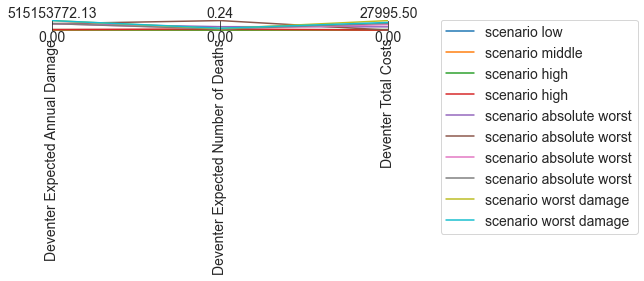

In [8]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policies.iloc[:, 10:13])

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for index, row in policies.iterrows():
    color = next(colors)
    paraxes.plot(row, label=f'scenario {cases[row.scenario]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.tight_layout()
plt.show()


# Reevaluate under deep uncertainty

## Reading
Read in the results from the reevaluate under deep uncertainty


In [9]:
n_scenarios = 1000

In [10]:
du_experiments, du_outcomes = load_results("simulation/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

### Keep only the DU experiments and outcomes that are in POLICIES
This way only the selected policies (and the respective scenarios) are brought into the rest of the analysis.

In [11]:
du_outcomes_df = pd.DataFrame.from_dict(du_outcomes)
merged_du = pd.concat([du_experiments, du_outcomes_df], axis=1)
merged_du.head(5)

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,A.0_ID flood wave shape,...,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,scenario,policy,model,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,51.0,...,1.0,2.0,0.0,0.0,1000,scenario best option 0,dikesnet,7.550464e+07,0.030320,3044.580453
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,108.0,...,1.0,2.0,0.0,0.0,1001,scenario best option 0,dikesnet,2.968128e+08,0.072625,8258.317156
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1002,scenario best option 0,dikesnet,0.000000e+00,0.000000,0.000000
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,101.0,...,1.0,2.0,0.0,0.0,1003,scenario best option 0,dikesnet,1.216972e+07,0.005227,481.619923
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,36.0,...,1.0,2.0,0.0,0.0,1004,scenario best option 0,dikesnet,6.661154e+06,0.003266,303.355467


In [12]:
#now compare the policies in merged_du to the policies in 'policies' 
policies_policy_df = policies.iloc[:, 0:10]
DU_policy_selected_df = pd.merge(policies_policy_df, merged_du, how = "inner")
DU_policy_selected_df.head(5)

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,...,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0,1,1,1,0,0,0,0,0,9,0,...,0.145196,4.5,4.5,2.5,1000,scenario low option 0,dikesnet,3.893922e+07,0.043001,0.0
1,1,1,1,0,0,0,0,0,9,0,...,0.048297,1.5,2.5,1.5,1001,scenario low option 0,dikesnet,1.174954e+08,0.085181,0.0
2,1,1,1,0,0,0,0,0,9,0,...,0.799841,3.5,2.5,1.5,1002,scenario low option 0,dikesnet,0.000000e+00,0.000000,0.0
3,1,1,1,0,0,0,0,0,9,0,...,0.644478,3.5,3.5,4.5,1003,scenario low option 0,dikesnet,2.147294e+06,0.002632,0.0
4,1,1,1,0,0,0,0,0,9,0,...,0.624614,3.5,4.5,4.5,1004,scenario low option 0,dikesnet,0.000000e+00,0.000000,0.0


#### rewrite du_experiments and du_outcomes with the filtered version

In [13]:
du_outcomes_policy_df = DU_policy_selected_df[DU_policy_selected_df.columns[-3:]].copy()
du_experiments = DU_policy_selected_df[DU_policy_selected_df.columns[0:50]].copy()
du_outcomes = du_outcomes_policy_df.to_dict('series')

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [14]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Deventer Expected Annual Damage',
 'Deventer Expected Number of Deaths',
 'Deventer Total Costs']

In [15]:
DAMAGE = outcomekeys[0]
DEATHS = outcomekeys[1]
COSTS = outcomekeys[2]

#### Regret calculation based on assignments

In [16]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    best = temp_results.min() #we are minimizing
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [17]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max().dropna()#dropna to remove some artifacts that were left

In [18]:
maxregret

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
policy,,,
scenario absolute worst option 0,1.975364e+08,0.158755,29976.698139
scenario absolute worst option 1,1.960830e+08,0.022271,61826.939912
scenario absolute worst option 2,1.975364e+08,0.028105,49766.002770
scenario absolute worst option 3,1.975364e+08,0.581652,0.000000
scenario high option 0,1.969750e+08,0.581652,0.000000
scenario high option 1,1.974474e+08,0.028085,49766.002770
scenario low option 0,1.486332e+08,0.581184,0.000000
scenario middle option 0,1.975364e+08,0.022484,72131.429897
scenario worst damage option 0,0.000000e+00,0.019781,49698.225742


### renaming policies for legend and colourssss
rename policy names to things that will stick and we'll remember
In the order that they are above, replace with 
D_0, D_1, ...  D_10, D_11,

At the same time create a dictionary for the colours that is linked to the policy name, so that for the following graphs, the same policies have the same colour.

In [19]:
#naming and colour block
old_names = maxregret.index.values.tolist()
new_names = []
dict_naming = {}

for i in range(len(maxregret)):
    name = "D_" + str(i)
    #print(name)
    new_names.append(name)
dict_naming = {old_names[i]: new_names[i] for i in range(len(old_names))}
#dict_naming  

#Dictionary for the coloursss
color_list =  sns.color_palette('Spectral',len(old_names))
dict_colours = {old_names[i]: color_list[i] for i in range(len(old_names))}


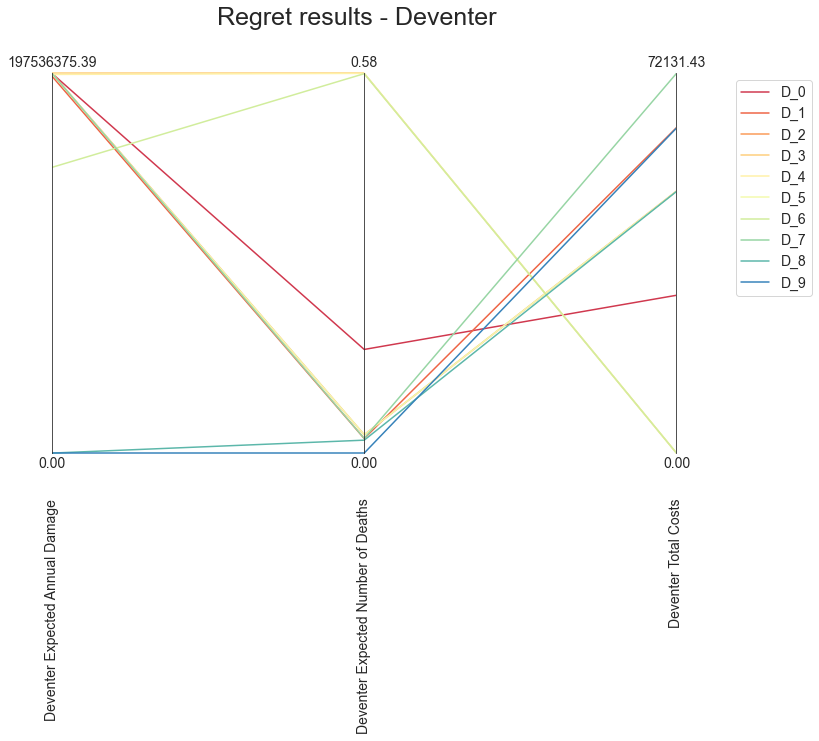

In [20]:
from matplotlib import cm

limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)


for index, row in maxregret.iterrows():
    paraxes.plot(row, color=dict_colours[index], label=dict_naming[index])
    
paraxes.legend()
plt.figtext(.5,1,'Regret results - Deventer',fontsize=25,ha='center')

plt.savefig("../../report/figures/results/regret_figure"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

For the satisficing analysis, the domain criterion metric from the assignments and as discussed in the paper: [(Bartholomew, Kwakkel 2020)](https://repository.tudelft.nl/islandora/object/uuid%3A17668d72-4ae4-47a4-9905-ebb0e1e75128). Another option that we explored was looking over the policies and seeing if there are any policies that are within all three thresholds. 

The threshold values are found within funs_project.py and sources can be found within the acompanying report.

In [21]:
satisfycing_df = policies.copy()
satisfycing_df.drop_duplicates(inplace=True)
#satisfycing_df

In [22]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Deventer Expected Annual Damage'] < fp.thresholds_deventer['Deventer Expected Annual Damage']) & \
                    (satisfycing_df['Deventer Expected Number of Deaths'] < fp.thresholds_deventer['Deventer Expected Number of Deaths']) & \
                    (satisfycing_df['Deventer Total Costs'] < fp.thresholds_deventer['Deventer Total Costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,scenario
2,1,1,1,0,0,0,4,10,10,5,0.0,0.0,0.0,2
1,1,1,1,0,0,0,0,0,9,0,0.0,0.0,0.0,1


From the 12 selected policies there are two policies that fall completly within all the thresholds for Deventer. 

### Domain-criterion analysis

In [23]:
limits_df = belowtresh_df.iloc[:, -4:-1]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

In [24]:

overall_scores = {}
for policy in du_experiments.policy.unique():
    logical = du_experiments.policy == policy
    scores = {}
    for k, v in du_outcomes.items():
        try:
            n = np.sum(v[logical]<=fp.thresholds_deventer[k])#check if it is below thresholds
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

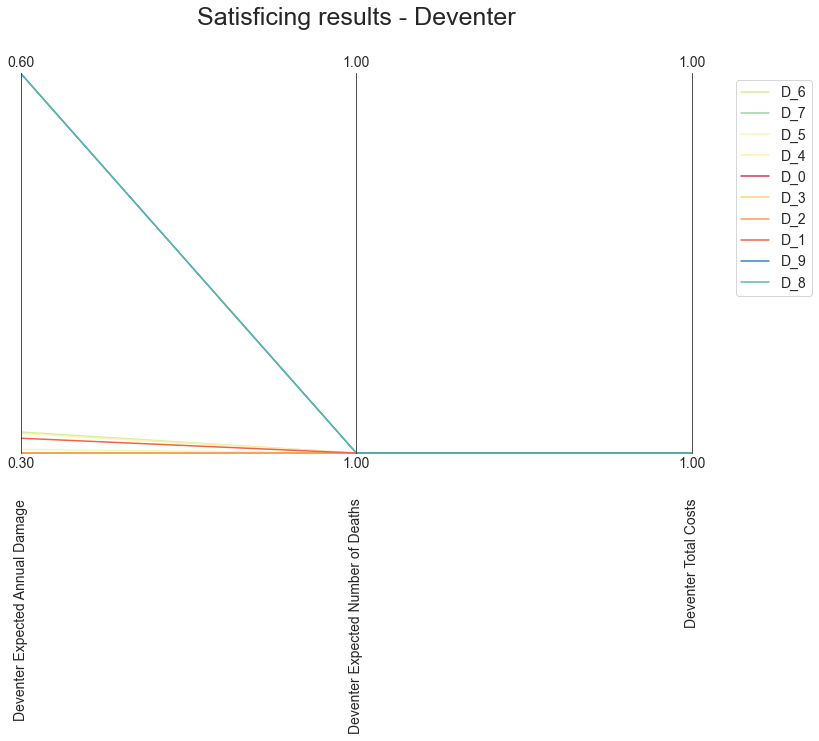

In [25]:
from matplotlib import cm

limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)

for index, row in overall_scores.iterrows():
    paraxes.plot(row, color=dict_colours[index], label=dict_naming[index])
    
paraxes.legend()
plt.figtext(.5,1,'Satisficing results - Deventer',fontsize=25,ha='center')

plt.savefig("../../report/figures/results/domain_criterion"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

In [26]:
overall_scores

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
scenario low option 0,0.313,1.0,1.0
scenario middle option 0,0.296,1.0,1.0
scenario high option 1,0.299,1.0,1.0
scenario high option 0,0.312,1.0,1.0
scenario absolute worst option 0,0.296,1.0,1.0
scenario absolute worst option 3,0.296,1.0,1.0
scenario absolute worst option 2,0.296,1.0,1.0
scenario absolute worst option 1,0.308,1.0,1.0
scenario worst damage option 3,0.603,1.0,1.0
scenario worst damage option 0,0.603,1.0,1.0


## Scoring policies
This part combines the results from both robustness measures to score the policies and select the most robust 5 policies. The regret results are normalised first to make it possible to get a 'good' average. This will be done by first taking the average of the two metrics and than sorting first by the domain-criterion and then by regret.

### Normalise the regret and take the average to score the policies


In [27]:
from sklearn import preprocessing

In [28]:
#Normalize the regret results
regret_scores = maxregret.copy()
regret_average = regret_scores.apply(lambda x: x/x.max(), axis=0)

In [29]:
#Get the average for each policy
regret_average['average regret'] = regret_average.mean(numeric_only=True, axis=1)
regret_average.sort_values(by='average regret', ascending = False, inplace = True) #Lower = better
regret_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
policy,,,,
scenario middle option 0,1.000000,0.038655,1.000000,0.679552
scenario absolute worst option 3,1.000000,1.000000,0.000000,0.666667
scenario high option 0,0.997158,1.000000,0.000000,0.665719
scenario absolute worst option 1,0.992642,0.038290,0.857143,0.629358
scenario low option 0,0.752435,0.999197,0.000000,0.583877
scenario absolute worst option 2,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.000000,0.000000,0.855976,0.285325


###  Use the satisficing / domain criterion and take their average to score the policies


In [30]:
#Get the average for each policy
satisficing_average = overall_scores.copy()
satisficing_average['average satisficing'] = satisficing_average.mean(numeric_only=True, axis=1)
satisficing_average.sort_values(by='average satisficing', ascending = True, inplace = True) #higher = better
satisficing_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing
scenario middle option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 3,0.296,1.0,1.0,0.765333
scenario absolute worst option 2,0.296,1.0,1.0,0.765333
scenario high option 1,0.299,1.0,1.0,0.766333
scenario absolute worst option 1,0.308,1.0,1.0,0.769333
scenario high option 0,0.312,1.0,1.0,0.770667
scenario low option 0,0.313,1.0,1.0,0.771000
scenario worst damage option 3,0.603,1.0,1.0,0.867667
scenario worst damage option 0,0.603,1.0,1.0,0.867667


### Add them together  

In [31]:
merged_df = pd.concat([satisficing_average, regret_average], join="inner", axis = 1)


In [32]:
merged_df.sort_values(by='average satisficing', inplace = True, ascending = True)
merged_df.sort_values(by='average regret', inplace = True, ascending = False)
merged_df

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario middle option 0,0.296,1.0,1.0,0.765333,1.000000,0.038655,1.000000,0.679552
scenario absolute worst option 3,0.296,1.0,1.0,0.765333,1.000000,1.000000,0.000000,0.666667
scenario high option 0,0.312,1.0,1.0,0.770667,0.997158,1.000000,0.000000,0.665719
scenario absolute worst option 1,0.308,1.0,1.0,0.769333,0.992642,0.038290,0.857143,0.629358
scenario low option 0,0.313,1.0,1.0,0.771000,0.752435,0.999197,0.000000,0.583877
scenario absolute worst option 2,0.296,1.0,1.0,0.765333,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.299,1.0,1.0,0.766333,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.603,1.0,1.0,0.867667,0.000000,0.000000,0.855976,0.285325
scenario worst damage option 0,0.603,1.0,1.0,0.867667,0.000000,0.034009,0.688995,0.241001


In [33]:
#take te most robust policies and put them into a df.
robust_policies = merged_df.tail(5)
robust_policies

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario absolute worst option 2,0.296,1.0,1.0,0.765333,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.299,1.0,1.0,0.766333,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.603,1.0,1.0,0.867667,0.000000,0.000000,0.855976,0.285325
scenario worst damage option 0,0.603,1.0,1.0,0.867667,0.000000,0.034009,0.688995,0.241001


The policies above show that there often is a trade-off between satisficing and regret. 

## Tying it back to the policy levers.

In [34]:
#now to return to an original list of policies with this
policy_names = robust_policies.index.values.tolist()

In [35]:
temp_results = DU_policy_selected_df[DU_policy_selected_df['policy'].isin(policy_names)]

In [36]:
lever_names = policies_policy_df.columns.values.tolist()


In [37]:
robust_policies_results = temp_results[lever_names].drop_duplicates()

In [38]:
robust_policies_results

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2
2000,1,1,1,0,0,0,2,5,9,9
4000,1,1,1,0,0,0,1,8,10,9
6000,1,1,1,0,0,0,2,8,8,4
8000,1,1,1,0,0,0,3,0,0,0
9000,1,1,1,0,0,0,2,0,0,0


In [39]:
robust_policies_results.to_csv('simulation/selected/selected_policies_' + ACTORNAME + '.csv')

In [40]:
lever_names.append('policy')
robust_policies_results_names = temp_results[lever_names].drop_duplicates()
robust_policies_results_names.set_index('policy', inplace = True)
robust_policies_results_names

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2
policy,,,,,,,,,,
scenario high option 1,1,1,1,0,0,0,2,5,9,9
scenario absolute worst option 0,1,1,1,0,0,0,1,8,10,9
scenario absolute worst option 2,1,1,1,0,0,0,2,8,8,4
scenario worst damage option 3,1,1,1,0,0,0,3,0,0,0
scenario worst damage option 0,1,1,1,0,0,0,2,0,0,0
